# Análise de Regressão - Olist Freight Value

## Objetivo
Prever o valor do frete (freight_value) usando diferentes modelos de regressão.

## Requisitos Obrigatórios
- ✅ Regressão Linear
- ✅ PCA para redução de dimensionalidade  
- ✅ 3 Métricas: R², MAE, RMSE

## Modelos Comparados
1. **Linear Regression** (obrigatório)
2. **Random Forest Regressor**
3. **Decision Tree Regressor**


In [1]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics

print("Bibliotecas importadas com sucesso!")


Bibliotecas importadas com sucesso!


## 1. Carregamento dos Dados

In [2]:
# Carregar datasets
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
orders = pd.read_csv('data/olist_orders_dataset.csv')
customers = pd.read_csv('data/olist_customers_dataset.csv')
sellers = pd.read_csv('data/olist_sellers_dataset.csv')
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')

print("Dados carregados:")


Dados carregados:


## 2. Features

In [3]:
# Criar feature de volume do produto
products['volume'] = (products['product_length_cm'] * 
                      products['product_height_cm'] * 
                      products['product_width_cm'])

# Preencher valores ausentes na categoria
products['product_category_name'] = products['product_category_name'].fillna('Indefinido')

print("Features criadas")

Features criadas


## 3. Merge e Preparação dos Dados

In [4]:
# Merge dos dados
data = (order_items
        .merge(products, on='product_id')
        .merge(orders, on='order_id')
        .merge(customers, on='customer_id')
        .merge(sellers, on='seller_id')
        .merge(reviews, on='order_id'))

print("Dados unidos")


Dados unidos


## 4. Criação de Features

In [5]:
# Criar feature binária: mesmo estado?
data['same_state'] = (data['customer_state'] == data['seller_state']).astype(int)

# Codificar variáveis categóricas
data['customer_state'] = data['customer_state'].astype('category').cat.codes
data['seller_state'] = data['seller_state'].astype('category').cat.codes
data['product_category'] = data['product_category_name'].astype('category').cat.codes

# Definir features para o modelo
features = [
    'volume', 
    'product_weight_g', 
    'customer_state', 
    'seller_state', 
    'same_state', 
    'product_category'
]

# Preparar X e y (removendo NaN)
X = data[features].dropna()
y = data.loc[X.index, 'freight_value']

print(f"Features criadas: {features}")
print(f"Target (Frete) - média: R$ {y.mean():.2f}")


Features criadas: ['volume', 'product_weight_g', 'customer_state', 'seller_state', 'same_state', 'product_category']
Target (Frete) - média: R$ 19.98


## 5. Train/Test Split e Normalização

In [6]:
# Dividir em treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados (necessário para PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Divisão dos dados (20/80)")
print("Normalização aplicada com StandardScaler")

Divisão dos dados (20/80)
Normalização aplicada com StandardScaler


## 6. PCA - Redução de Dimensionalidade (Obrigatório)

In [7]:
# Aplicar PCA mantendo 95% da variância
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("PCA aplicado:")
print(f"Dimensões originais: {X_train_scaled.shape[1]}")
print(f"Dimensões após PCA: {X_train_pca.shape[1]}")
print(f"\nComponentes principais mantidos: {len(pca.explained_variance_ratio_)}")
print(f"Features originais: {features}")


PCA aplicado:
Dimensões originais: 6
Dimensões após PCA: 5

Componentes principais mantidos: 5
Features originais: ['volume', 'product_weight_g', 'customer_state', 'seller_state', 'same_state', 'product_category']


## 7. Definição dos Modelos de Regressão

In [8]:
# Definir os 3 modelos para comparação
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(
        n_estimators=100, 
        max_depth=15, 
        min_samples_leaf=2, 
        max_features='sqrt', 
        random_state=42, 
        n_jobs=-1
    ),
    'Decision Tree': DecisionTreeRegressor(
        max_depth=15, 
        min_samples_leaf=2, 
        ccp_alpha=0.0, 
        random_state=42
    )
}

print("Modelos definidos:")
for i, model_name in enumerate(models.keys(), 1):
    print(f"   {i}. {model_name}")


Modelos definidos:
   1. Linear Regression
   2. Random Forest
   3. Decision Tree


## 8. Treinamento e Avaliação dos Modelos

In [9]:
# Dicionário para armazenar resultados
results = {}

# Treinar e avaliar cada modelo
for model_name, model in models.items():
    print(f"{'='*60}")
    print(f"Modelo: {model_name}")
    print(f"{'='*60}")
    
    # Treinar modelo
    model.fit(X_train_pca, y_train)
    
    # Predições
    y_pred = model.predict(X_test_pca)
    
    # Calcular as 3 métricas obrigatórias
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    
    # Calcular acurácia com tolerância
    tolerance = 0.2  # 20% de tolerância
    accuracy = (abs(y_test - y_pred) / y_test <= tolerance).mean() * 100
    
    # Armazenar resultados
    results[model_name] = {
        'R²': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Acurácia (±20%)': accuracy
    }
    
    # Exibir métricas
    print(f"R² Score: {r2:.4f}")
    print(f"MAE (Mean Absolute Error): R$ {mae:.2f}")
    print(f"RMSE (Root Mean Squared Error): R$ {rmse:.2f}")
    print(f"Predições dentro de ±20%: {accuracy:.2f}%")
    print()

print("Todos os modelos foram treinados e avaliados!")


Modelo: Linear Regression
R² Score: 0.5225
MAE (Mean Absolute Error): R$ 5.96
RMSE (Root Mean Squared Error): R$ 10.98
Predições dentro de ±20%: 49.25%

Modelo: Random Forest
R² Score: 0.7177
MAE (Mean Absolute Error): R$ 4.20
RMSE (Root Mean Squared Error): R$ 8.45
Predições dentro de ±20%: 68.43%

Modelo: Decision Tree
R² Score: 0.7177
MAE (Mean Absolute Error): R$ 4.20
RMSE (Root Mean Squared Error): R$ 8.45
Predições dentro de ±20%: 68.43%

Modelo: Decision Tree
R² Score: 0.6112
MAE (Mean Absolute Error): R$ 4.59
RMSE (Root Mean Squared Error): R$ 9.91
Predições dentro de ±20%: 67.31%

Todos os modelos foram treinados e avaliados!
R² Score: 0.6112
MAE (Mean Absolute Error): R$ 4.59
RMSE (Root Mean Squared Error): R$ 9.91
Predições dentro de ±20%: 67.31%

Todos os modelos foram treinados e avaliados!


## 9. Comparação dos Modelos

In [10]:
# Tabela comparativa dos modelos
print(f"{'='*70}")
print("COMPARAÇÃO DOS MODELOS")
print(f"{'='*70}")
print(f"{'Modelo':<25} {'R²':<10} {'MAE':<12} {'RMSE':<12} {'Acurácia':<10}")
print(f"{'-'*70}")

for model_name, metrics in results.items():
    print(f"{model_name:<25} {metrics['R²']:<10.4f} R$ {metrics['MAE']:<9.2f} R$ {metrics['RMSE']:<9.2f} {metrics['Acurácia (±20%)']:<9.2f}%")

# Identificar o melhor modelo baseado em R²
best_model = max(results.items(), key=lambda x: x[1]['R²'])
print(f"\n{'='*70}")
print(f"Melhor modelo (por R²): {best_model[0]}")
print(f"   - R² Score: {best_model[1]['R²']:.4f}")
print(f"   - MAE: R$ {best_model[1]['MAE']:.2f}")
print(f"   - RMSE: R$ {best_model[1]['RMSE']:.2f}")
print(f"   - Acurácia (±20%): {best_model[1]['Acurácia (±20%)']:.2f}%")
print(f"{'='*70}")


COMPARAÇÃO DOS MODELOS
Modelo                    R²         MAE          RMSE         Acurácia  
----------------------------------------------------------------------
Linear Regression         0.5225     R$ 5.96      R$ 10.98     49.25    %
Random Forest             0.7177     R$ 4.20      R$ 8.45      68.43    %
Decision Tree             0.6112     R$ 4.59      R$ 9.91      67.31    %

Melhor modelo (por R²): Random Forest
   - R² Score: 0.7177
   - MAE: R$ 4.20
   - RMSE: R$ 8.45
   - Acurácia (±20%): 68.43%


## 9.1. Visualização das Métricas

C:\Users\lnata\AppData\Local\Temp\ipykernel_31344\4252528563.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=15, ha='right')
C:\Users\lnata\AppData\Local\Temp\ipykernel_31344\4252528563.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=15, ha='right')
C:\Users\lnata\AppData\Local\Temp\ipykernel_31344\4252528563.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=15, ha='right')


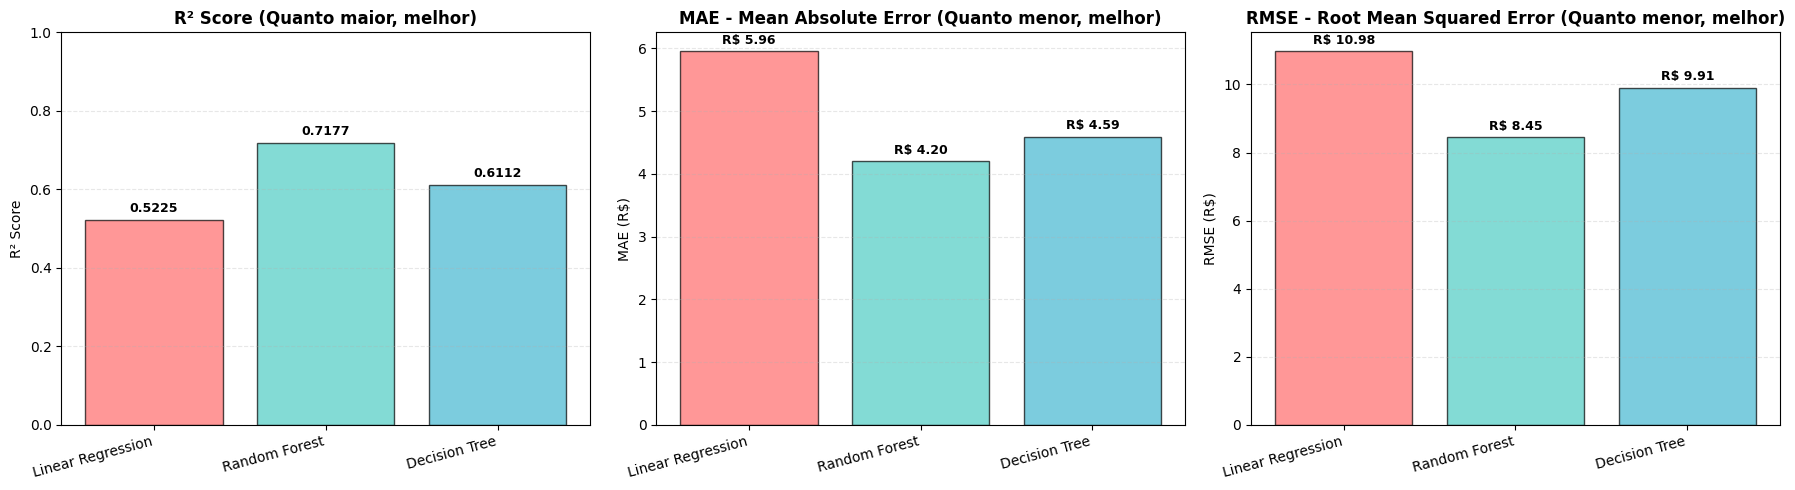

Gráficos de métricas gerados!


In [11]:
import matplotlib.pyplot as plt

# Preparar dados para visualização
model_names = list(results.keys())
r2_scores = [results[m]['R²'] for m in model_names]
mae_scores = [results[m]['MAE'] for m in model_names]
rmse_scores = [results[m]['RMSE'] for m in model_names]

# Criar figura com 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Cores para cada modelo
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# 1. R² Score
axes[0].bar(model_names, r2_scores, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_title('R² Score (Quanto maior, melhor)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('R² Score', fontsize=10)
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(r2_scores):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=9, fontweight='bold')

# 2. MAE (Mean Absolute Error)
axes[1].bar(model_names, mae_scores, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_title('MAE - Mean Absolute Error (Quanto menor, melhor)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MAE (R$)', fontsize=10)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(mae_scores):
    axes[1].text(i, v + max(mae_scores)*0.02, f'R$ {v:.2f}', ha='center', fontsize=9, fontweight='bold')

# 3. RMSE (Root Mean Squared Error)
axes[2].bar(model_names, rmse_scores, color=colors, alpha=0.7, edgecolor='black')
axes[2].set_title('RMSE - Root Mean Squared Error (Quanto menor, melhor)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('RMSE (R$)', fontsize=10)
axes[2].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(rmse_scores):
    axes[2].text(i, v + max(rmse_scores)*0.02, f'R$ {v:.2f}', ha='center', fontsize=9, fontweight='bold')

# Rotacionar labels do eixo X
for ax in axes:
    ax.set_xticklabels(model_names, rotation=15, ha='right')

plt.tight_layout()
plt.show()

print("Gráficos de métricas gerados!")

## 9.2. Curvas de Aprendizado

Gerando curva de aprendizado para Linear Regression...
Gerando curva de aprendizado para Random Forest...
Gerando curva de aprendizado para Random Forest...
Gerando curva de aprendizado para Decision Tree...
Gerando curva de aprendizado para Decision Tree...


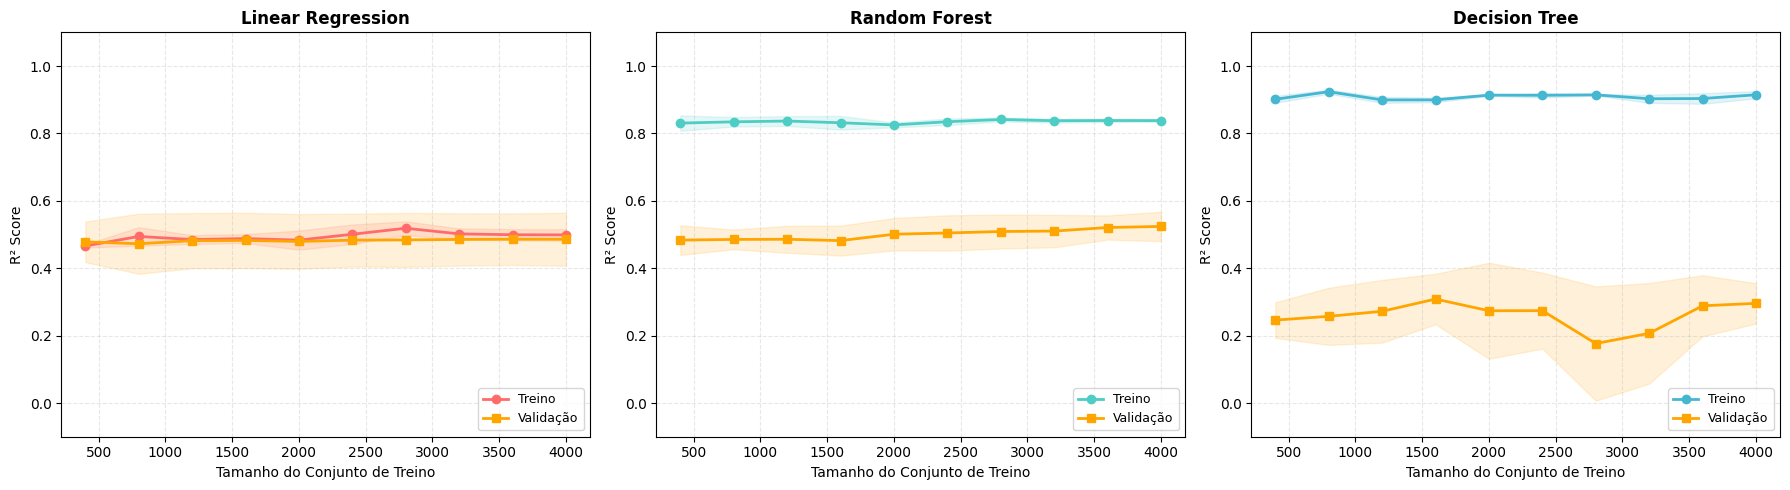


Curvas de aprendizado geradas!


In [12]:
from sklearn.model_selection import learning_curve

# Configurar figura para curvas de aprendizado
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Cores para cada modelo
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Gerar curvas de aprendizado para cada modelo
for idx, (model_name, model) in enumerate(models.items()):
    ax = axes[idx]
    
    print(f"Gerando curva de aprendizado para {model_name}...")
    
    # Calcular curva de aprendizado
    # Usar amostra menor para acelerar o processo
    sample_size = min(5000, len(X_train_pca))
    sample_indices = np.random.choice(len(X_train_pca), size=sample_size, replace=False)
    X_sample = X_train_pca[sample_indices]
    y_sample = y_train.iloc[sample_indices]
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, 
        X_sample, 
        y_sample,
        cv=5,  # 5-fold cross-validation
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='r2',
        n_jobs=-1,
        random_state=42
    )
    
    # Calcular médias e desvios padrão
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Plotar curvas
    ax.plot(train_sizes, train_mean, 'o-', color=colors[idx], label='Treino', linewidth=2, markersize=6)
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color=colors[idx])
    
    ax.plot(train_sizes, val_mean, 's-', color='orange', label='Validação', linewidth=2, markersize=6)
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='orange')
    
    # Configurar subplot
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Tamanho do Conjunto de Treino', fontsize=10)
    ax.set_ylabel('R² Score', fontsize=10)
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.show()

print("\nCurvas de aprendizado geradas!")

10. Features

In [4]:
# Criar feature de volume do produto
data['time_to_deliver'] = (pd.to_datetime(data['order_delivered_customer_date']) - pd.to_datetime(data['order_purchase_timestamp'])).dt.days

print("Features criadas")

Features criadas


11. Criação das Features

In [5]:
# Definir features para o modelo
features = [
    'price',
    'freight_value'
]

# Preparar X e y (removendo NaN)
X = data[features].dropna()
y = data.loc[X.index, 'review_score']

print(f"Features criadas: {features}")
print(f"Target (Review Score) - média: {y.mean():.2f}")

Features criadas: ['price', 'freight_value']
Target (Review Score) - média: 4.03


12. Train Test Split

In [6]:
# Dividir em treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados (necessário para PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Divisão dos dados (20/80)")
print("Normalização aplicada com StandardScaler")

Divisão dos dados (20/80)
Normalização aplicada com StandardScaler


13. PCA - Redução de Dimensionalidade (Obrigatório)

In [7]:
# Aplicar PCA mantendo 95% da variância
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("PCA aplicado:")
print(f"Dimensões originais: {X_train_scaled.shape[1]}")
print(f"Dimensões após PCA: {X_train_pca.shape[1]}")
print(f"\nComponentes principais mantidos: {len(pca.explained_variance_ratio_)}")
print(f"Features originais: {features}")


PCA aplicado:
Dimensões originais: 2
Dimensões após PCA: 2

Componentes principais mantidos: 2
Features originais: ['price', 'freight_value']


14. Definição dos Modelos de Clustering

In [8]:
# Definir os 3 modelos para comparação
models = {
    'K-Means': KMeans(
        init='k-means++',
        n_clusters=4,
    ),
    'DBSCAN': DBSCAN(
        eps=0.8,
        min_samples=5
    ),
    'Agglomerative Clustering': AgglomerativeClustering(
        n_clusters=4,
        linkage='ward'
    )
}

print("Modelos definidos:")
for i, model_name in enumerate(models.keys(), 1):
    print(f"   {i}. {model_name}")

Modelos definidos:
   1. K-Means
   2. DBSCAN
   3. Agglomerative Clustering


15. Treinamento e Avaliação dos Modelos de Clustering

In [ ]:
from collections import Counter

# Treinar e avaliar modelos de clustering
# Usando amostra de 10.000 pontos para reduzir tempo e memória
sample_size = 10000
np.random.seed(42)
sample_indices = np.random.choice(len(X_train_pca), size=min(sample_size, len(X_train_pca)), replace=False)
X_train_sample = X_train_pca[sample_indices]

cluster_results = {}

for model_name, model in models.items():
    print(f"{'='*60}")
    print(f"Modelo: {model_name}")
    print(f"{'='*60}")
    
    # Treinar e obter rótulos na amostra
    labels = model.fit_predict(X_train_sample)
    
    # Informações de clusters
    label_counts = dict(Counter(labels))
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_count = int(label_counts.get(-1, 0))
    
    # Métricas (só calculáveis se houver pelo menos 2 clusters)
    sil_score = None
    ch_score = None
    db_score = None
    if n_clusters > 1:
        try:
            sil_score = metrics.silhouette_score(X_train_sample, labels)
            ch_score = metrics.calinski_harabasz_score(X_train_sample, labels)
            db_score = metrics.davies_bouldin_score(X_train_sample, labels)
        except Exception as e:
            # caso raro de erro numérico
            sil_score = ch_score = db_score = None
    
    # Inércia (apenas KMeans possui)
    inertia = getattr(model, 'inertia_', None)
    
    # Armazenar resultados
    cluster_results[model_name] = {
        'n_clusters': n_clusters,
        'cluster_counts': label_counts,
        'noise_count': noise_count,
        'inertia': float(inertia) if inertia is not None else None,
        'silhouette': float(sil_score) if sil_score is not None else None,
        'calinski_harabasz': float(ch_score) if ch_score is not None else None,
        'davies_bouldin': float(db_score) if db_score is not None else None,
        'labels_sample': labels[:10].tolist()  # amostra dos rótulos
    }
    
    # Exibir métricas resumidas
    print(f"Clusters encontrados (excluindo ruído): {n_clusters}")
    print(f"Contagem por rótulo (inclui -1 para ruído): {label_counts}")
    if inertia is not None:
        print(f"Inertia: {inertia:.4f}")
    print(f"Silhouette: {sil_score if sil_score is not None else 'N/A'}")
    print(f"Calinski-Harabasz: {ch_score if ch_score is not None else 'N/A'}")
    print(f"Davies-Bouldin: {db_score if db_score is not None else 'N/A'}")
    print()

print(f"Avaliação de clustering concluída (amostra de {len(X_train_sample):,} pontos).")
# resultados disponíveis em `cluster_results`

Modelo: K-Means


KeyboardInterrupt: 

## 16. Visualização dos Clusters

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Criar amostra para visualização
# sample_size = 10000
# np.random.seed(42)
# sample_indices = np.random.choice(len(X_train_pca), size=min(sample_size, len(X_train_pca)), replace=False)
X_sample = X_train_pca#[sample_indices]

# Configurar figura com subplots para os modelos
n_models = len(models)
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
if n_models == 1:
    axes = [axes]
fig.suptitle(f'Visualização dos Clusters - Features: Price + Freight Value (Amostra de {len(X_sample):,} pontos)', fontsize=16, y=1.02)

# Cores para clusters (incluindo ruído como cinza)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E2']
noise_color = '#808080'

for idx, (model_name, model) in enumerate(models.items()):
    ax = axes[idx]
    
    print(f"Processando {model_name}...")
    
    # Obter labels do clustering na amostra
    labels = model.fit_predict(X_sample)
    
    # Plotar pontos
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    
    for label in unique_labels:
        if label == -1:
            # Ruído (DBSCAN)
            color = noise_color
            marker = 'x'
            label_name = 'Ruído'
            alpha = 0.3
        else:
            color = colors[label % len(colors)]
            marker = 'o'
            label_name = f'Cluster {label}'
            alpha = 0.6
        
        mask = labels == label
        ax.scatter(
            X_sample[mask, 0], 
            X_sample[mask, 1] if X_sample.shape[1] > 1 else X_sample[mask, 0],
            c=color,
            label=label_name,
            alpha=alpha,
            edgecolors='black',
            linewidth=0.5,
            marker=marker,
            s=30
        )
    
    # Configurar subplot
    ax.set_title(f'{model_name}\n({n_clusters} clusters)', fontsize=12, fontweight='bold')
    ax.set_xlabel('PCA Component 1 (Price)', fontsize=10)
    ax.set_ylabel('PCA Component 2 (Freight)' if X_sample.shape[1] > 1 else 'PCA Component 1', fontsize=10)
    ax.legend(loc='upper right', fontsize=8, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\nVisualizações geradas para todos os modelos de clustering")

Processando K-Means...
Processando DBSCAN...
